<div style="page-break-after: always;"></div>

![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/001.png?raw=1)![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/002.jpeg?raw=1)

**M2.875 Deep Learning**

Práctica                    Autor: Oscar Rojo Martín

# *Clasificador Neuronal para la detección de Glaucoma*

<div style="page-break-after: always;"></div>

1.  Presentación

El objetivo de esta práctica es aplicar los conocimientos adquiridos durante toda la asignatura en un caso clínico real. Para ello se dispondrá de una base de datos que contiene imágenes de ojos sanos y de otros afectados por glaucoma. El glaucoma es una patología que afecta al nervio óptico y cuyos orígenes son diversos, es la segunda causa de ceguera por detrás de la diabetes y los efectos en la pérdida de visión son irreversibles. Las causas que lo producen se pueden tratar si la patología es detectada a tiempo.

El objetivo final de esta práctica es, mediante los conocimientos adquiridos, proponer y entrenar un algoritmo que sea capaz de detectar adecuadamente ojos con glaucoma frente a otros sanos.


  
1. Definición del problema

Los algoritmos de reconocimiento de imágenes se están implementando en la práctica clínica, integrándose en ocasiones directamente en el hardware que se utiliza para la exploración (por ejemplo, en los ecógrafos). Este tipo de aproximación es lo que se propone en el siguiente artículo científico, el cual se utilizará como base para realizar esta práctica:

- Diaz-Pinto, A., Morales, S., Naranjo, V. et al. *CNNs for automatic glaucoma assessment using fundus images: an extensive validation*. BioMed Eng OnLine 18, 29 (2019). <https://doi.org/10.1186/s12938-019-0649-y>

En esta práctica se dispone de una serie de imágenes de casos reales. El objetivo es obtener un modelo eficaz para detectar de manera temprana esta patología, reduciendo, por lo tanto, el riesgo de ceguera.

La base de datos está formada por imágenes en color de 224x224 píxeles y se ha dividido en 10 particiones distintas que se usarán para aplicar un método de *cross validation* con el objetivo de minimizar errores estadísticos. Cada una de estas particiones, a su vez, contiene tres subconjuntos: *train*, *test* y *valid*. Las imágenes a su vez están etiquetadas de dos formas: *normal* o *abnormal*.


2. Función de evaluación

La función de evaluación que se utilizará a lo largo de la práctica será el **F1-score**.

6. Recursos

El conjunto de los datos del proyecto se puede encontrar en la dirección:

- <https://www.kaggle.com/datasets/jordidelatorreuoc/practica-dl-uoc-2022>



#### Importar librerias

In [2]:
#!pip install tf-nightly

In [26]:
# Import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import asarray
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# mount the drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# go to the folder with the images
# % cd /content/drive/MyDrive/Colab Notebooks/DL-PRA

#### Cargar los datos desde kaggle usando API

In [4]:
# Import data from kaggle using Kaggle API
# ref.:https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953
# ! kaggle datasets download -d jordidelatorreuoc/practica-dl-uoc-2022


In [5]:
# unzip to data folder
# ! unzip -o practica-dl-uoc-2022.zip -d data/

In [6]:
# drop practica-dl-uoc-2022.zip
# ! rm practica-dl-uoc-2022.zip

In [7]:
# Load data
base_dir = 'data/practica_DL_UOC_2022/'

# list folder in data/practica-dl-uoc-2022/
subfolder = os.listdir(base_dir)
print(subfolder)


['Fold8', 'Fold2', 'Fold4', 'Fold3', 'Fold5', 'Fold1', 'Fold0', 'Fold9', 'Fold6', 'Fold7']


In [8]:
train_dir = os.path.join(base_dir, subfolder[0]+'/train/')
test_dir = os.path.join(base_dir, subfolder[0]+'/test/')
valid_dir = os.path.join(base_dir, subfolder[0]+'/valid/')

# directorio con imagenes normal de entrenamiento
train_normal_dir = os.path.join(train_dir, 'normal/')
# directorio con imagenes abnormal de entrenamiento
train_anormal_dir = os.path.join(train_dir, 'abnormal/')

# directorio con imagenes normal de test
test_normal_dir = os.path.join(test_dir, 'normal/')
# directorio con imagenes abnormal de test
test_anormal_dir = os.path.join(test_dir, 'abnormal/')

# directorio con imagenes normal de validacion
valid_normal_dir = os.path.join(valid_dir, 'normal/')
# directorio con imagenes abnormal de validacion
valid_anormal_dir = os.path.join(valid_dir, 'abnormal/')


In [9]:
train_anormal_dir_list = os.listdir(train_anormal_dir)
print(train_anormal_dir_list[0])

AUTPnKJWMk.jpg


#### Crear dataframe

In [10]:
df_all = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
train_test_valid = ['train', 'test', 'valid']
for i in subfolder:
    for h in train_test_valid:
        for j in norm_abnorm:
            x_dir = os.path.join(base_dir, i+'/'+h+'/'+j+'/')
            x_dir_list = os.listdir(x_dir)
            # create a dataframe with fold, set, status, image and full_path
            df = pd.DataFrame(x_dir_list, columns=['image'])
            df['fold'] = i
            df['set'] = h
            df['status'] = j
            df['full_path'] = df['image'].apply(lambda x: os.path.join(x_dir, x))
            df_all = pd.concat([df_all, df])

df_all 

,image,fold,set,status,full_path
0,cUMznzMsuV.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/c...
1,cheWWouKoz.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/c...
2,nwOhbmhYxy.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/n...
3,opYlvxALph.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/o...
4,GCXYbvgFbl.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/G...
...,...,...,...,...,...
67,iOPTDMYIet.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
68,cyMTZGIchB.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
69,VGUBrCcDtF.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
70,wGfehEkmNZ.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...


In [11]:
# Comprobar que el numero de imagenes es correcto

In [12]:
df_all_train = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        train_dir = os.path.join(base_dir, i+'/train/')
        train_dir_dir = os.path.join(train_dir, j+'/')
        train_dir_list = os.listdir(train_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_train = pd.DataFrame({'fold': [i]*len(train_dir_list),
                                    'set': [j]*len(train_dir_list),
                                    'status': [j]*len(train_dir_list),
                                    'image': train_dir_list,
                                    'full_path': [os.path.join(train_dir_dir, x) for x in train_dir_list]})
        df_all_train = pd.concat([df_all_train, df_train])

df_all_train.shape
    

(13790, 5)

In [13]:
df_all_test = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        test_dir = os.path.join(base_dir, i+'/test/')
        test_dir_dir = os.path.join(test_dir, j+'/')
        test_dir_list = os.listdir(test_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_test = pd.DataFrame({'fold': [i]*len(test_dir_list),
                                'set': [j]*len(test_dir_list),
                                'status': [j]*len(test_dir_list),
                                'image': test_dir_list,
                                'full_path': [os.path.join(test_dir_dir, x) for x in test_dir_list]})
        df_all_test = pd.concat([df_all_test, df_test])

df_all_test.shape


(1740, 5)

In [14]:
df_all_valid = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        valid_dir = os.path.join(base_dir, i+'/valid/')
        valid_dir_dir = os.path.join(valid_dir, j+'/')
        valid_dir_list = os.listdir(valid_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_valid = pd.DataFrame({'fold': [i]*len(valid_dir_list),
                                 'set': [j]*len(valid_dir_list),
                                 'status': [j]*len(valid_dir_list),
                                 'image': valid_dir_list,
                                 'full_path': [os.path.join(valid_dir_dir, x) for x in valid_dir_list]})
        df_all_valid = pd.concat([df_all_valid, df_valid])

df_all_valid.shape


(1540, 5)



# **Sección 1. Análisis Exploratorio de los datos (1,5 puntos)**

Realizar un análisis exploratorio de los datos proporcionados, tanto en formato numérico como gráfico, donde se recoja la información relevante del conjunto de datos proporcionado.


Dimensión: (17070, 5)


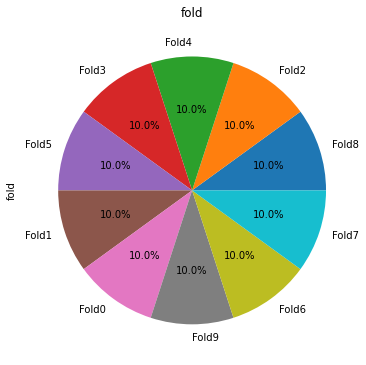

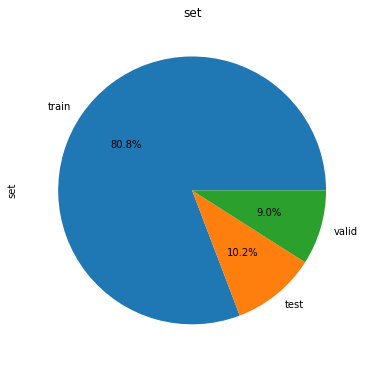

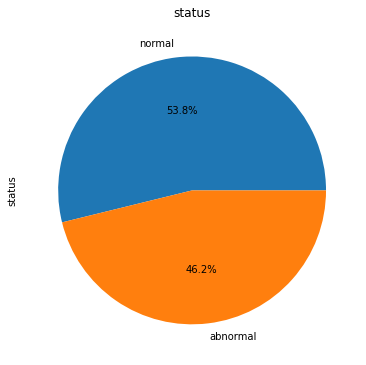

In [15]:
# Dimensión
print("Dimensión: {}".format(df_all.shape))

# list of columns
column_list = ['fold', 'set', 'status']   



# pie chart 
for i in column_list:
    df_all[i].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 10))
    plt.title(i)
    plt.show()




In [16]:
# load images
def load_image(path):
    image = Image.open(path)
    image = image.resize((224, 224))
    image = np.array(image)
    return image

load_image(df_all.iloc[0]['full_path'])


array([[[141,  41,  17],
        [142,  42,  18],
        [144,  44,  20],
        ...,
        [172,  46,  23],
        [174,  48,  25],
        [174,  48,  25]],

       [[141,  41,  17],
        [142,  42,  18],
        [144,  44,  20],
        ...,
        [173,  47,  24],
        [174,  48,  25],
        [174,  48,  25]],

       [[141,  41,  17],
        [142,  42,  18],
        [144,  44,  20],
        ...,
        [174,  48,  25],
        [174,  48,  25],
        [174,  48,  25]],

       ...,

       [[147,  56,  25],
        [147,  56,  25],
        [148,  57,  26],
        ...,
        [166,  40,  15],
        [166,  40,  17],
        [165,  39,  14]],

       [[146,  55,  24],
        [147,  56,  25],
        [148,  57,  26],
        ...,
        [166,  42,  14],
        [165,  41,  15],
        [164,  40,  12]],

       [[146,  55,  24],
        [147,  56,  25],
        [148,  57,  26],
        ...,
        [166,  42,  14],
        [165,  41,  13],
        [164,  40,  12]]

In [17]:
def image_info(path):
    image = Image.open(path)
    print(image.format)
    print(image.mode)
    print(image.size)
    


image_info(df_all.iloc[0]['full_path'])


JPEG
RGB
(224, 224)


In [18]:
def imagen(path):
    image = Image.open(path)
    pixels = asarray(image) # convert image to numpy array
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 14))
    ax0.imshow(image)
    ax0.axis('on')
    ax0.set_title('original image', fontsize=20)
    ax1.imshow(pixels)
    ax1.axis('on')
    ax1.set_title('result', fontsize=20)
    plt.show()

# imagen(df_all.iloc[0]['full_path'])

##### ojo sano:


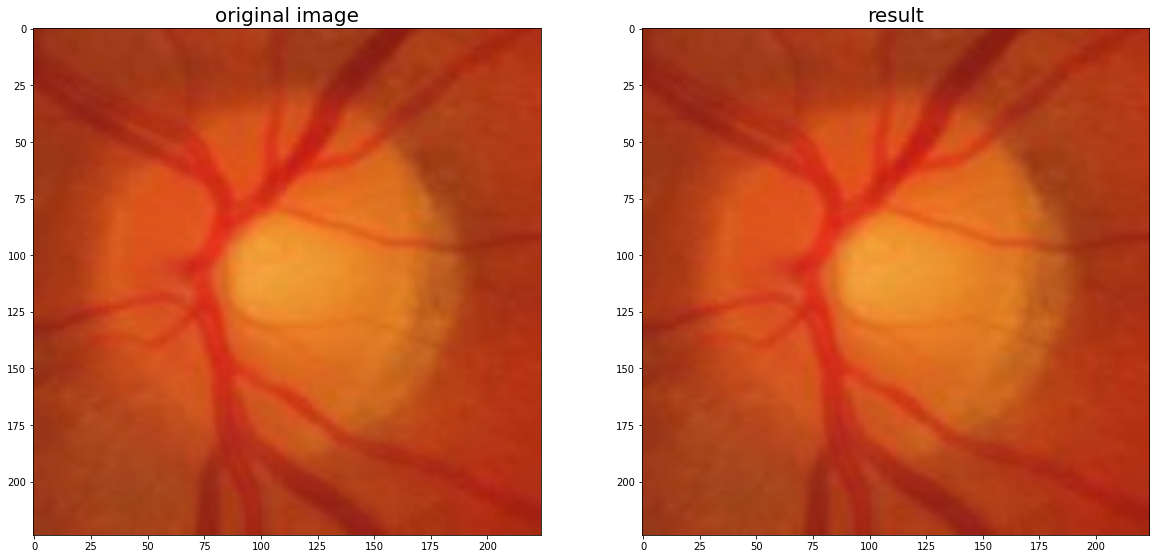

In [19]:
# filter df_all status = normal
df_all_normal = df_all[df_all['status'] == 'normal']
imagen(df_all_normal.iloc[0]['full_path'])

##### ojo con Glaucoma:


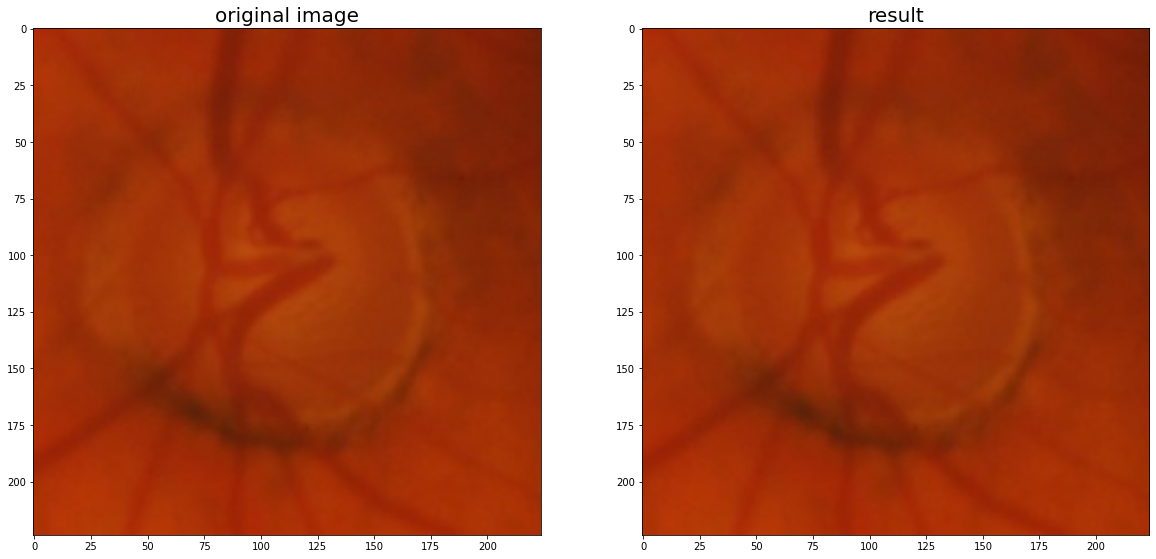

In [20]:
# filter df_all status = abnormal
df_all_abnormal = df_all[df_all['status'] == 'abnormal']
imagen(df_all_abnormal.iloc[0]['full_path'])


# **Sección 2. Entrenamiento de una red neuronal sobre una única partición (4 puntos)**

En esta primera parte se hará un entrenamiento únicamente sobre el **fold0**. Esto nos permitirá obtener conclusiones preliminares en un plazo razonable de tiempo, antes de ejecutar un entrenamiento completo empleando *cross validation* (ver sección 3). Para ello se deben proponer y comparar 5 aproximaciones distintas:

- Las 3 primeras configuraciones se deben implementar en un modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
  - En la primera configuración se entrena el modelo congelando todas las capas menos las que se han añadido al final (**modelo 1**).
  - En una segunda configuración, a partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas (**modelo 2**).
  - En la tercera configuración, a partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad (**modelo 3**).
- Entrenar dos configuraciones, modelos o arquitecturas adicionales, que se pueden escoger libremente (**modelo 4** y **modelo 5**).

En todos los casos, se debe indicar y justificar:

- Elegir la época e hiperparámetros que mejor resultados hayan proporcionado sobre el conjunto de validación durante el entrenamiento.
- Proporcionar y discutir los resultados sobre el conjunto de test.
- Obtener la matriz de confusión, y discutir los resultados teniendo en cuenta los objetivos del problema.


In [21]:
df_all

,image,fold,set,status,full_path
0,cUMznzMsuV.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/c...
1,cheWWouKoz.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/c...
2,nwOhbmhYxy.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/n...
3,opYlvxALph.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/o...
4,GCXYbvgFbl.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/G...
...,...,...,...,...,...
67,iOPTDMYIet.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
68,cyMTZGIchB.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
69,VGUBrCcDtF.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
70,wGfehEkmNZ.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...


In [22]:
# save df_all as csv
df_all.to_csv('data/df_all.csv', index=False)

In [23]:
# Filter data_all by fold
df_fold_0 = df_all[df_all['fold'] == 'Fold0']
df_fold_0.head()

df_fold_0_train = df_fold_0[df_fold_0['set'] == 'train']
df_fold_0_test = df_fold_0[df_fold_0['set'] == 'test']
df_fold_0_valid = df_fold_0[df_fold_0['set'] == 'valid']



### Modelo 1
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
Se entrena el modelo congelando todas las capas menos las que se han añadido al final 

In [24]:
#! echo 0 | sudo tee -a /sys/bus/pci/devices/NNNNN/numa_node

In [27]:
# Model 1
# Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*

prev_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model_1 = models.Sequential()
model_1.add(prev_model)
# sustituir la capa de clasificación por una capa GlobalAveragePooling2D
model_1.add(layers.GlobalAveragePooling2D())
# layer of "BatchNormalization"
model_1.add(layers.BatchNormalization())
# layer of "Dropout"
model_1.add(layers.Dropout(0.2))
# layer of Fully Connected
model_1.add(layers.Dense(1, activation='sigmoid'))

# train the model freeze all layers minus the last one

#for layer in model_1.layers[:-1]:
#    layer.trainable = False
model_1.layers[-1].trainable = True
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,055,972
Trainable params: 4,011,389
Non-

In [28]:
# compile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'], run_eagerly=True)
                


In [29]:
# convert df_fold_0_train['status'] to one-hot encoding
df_fold_0_train['status'] = df_fold_0_train['status'].map({'normal': 0, 'abnormal': 1})


/tmp/ipykernel_11725/126100849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fold_0_train['status'] = df_fold_0_train['status'].map({'normal': 0, 'abnormal': 1})


In [30]:
# convert df_fold_0_train to a numpy array
X_train = np.array([load_image(x) for x in df_fold_0_train['full_path']])
y_train = np.array(df_fold_0_train['status'])


In [31]:
# get max and min values of X_train
X_train_min = X_train.min()
X_train_max = X_train.max()
# normalize X_train
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)



In [32]:
print("X_train :",X_train.shape)
print("y_train :",y_train.shape)

X_train : (1379, 224, 224, 3)
y_train : (1379,)


In [33]:
print(X_train[0])

[[[0.50588235 0.27058824 0.03529412]
  [0.51372549 0.27843137 0.04313725]
  [0.51764706 0.28235294 0.04705882]
  ...
  [0.58039216 0.34509804 0.09803922]
  [0.57647059 0.3372549  0.09019608]
  [0.58039216 0.34117647 0.09411765]]

 [[0.51372549 0.27843137 0.04313725]
  [0.51764706 0.28235294 0.04705882]
  [0.51764706 0.28235294 0.04705882]
  ...
  [0.58823529 0.35294118 0.10588235]
  [0.58431373 0.34509804 0.09803922]
  [0.58431373 0.34509804 0.09803922]]

 [[0.50980392 0.26666667 0.03529412]
  [0.51372549 0.27058824 0.03921569]
  [0.51764706 0.2745098  0.04313725]
  ...
  [0.59215686 0.35686275 0.10980392]
  [0.58431373 0.34901961 0.10196078]
  [0.58431373 0.34901961 0.10196078]]

 ...

 [[0.54901961 0.27058824 0.01960784]
  [0.54509804 0.26666667 0.01568627]
  [0.54509804 0.26666667 0.01568627]
  ...
  [0.6627451  0.30588235 0.01960784]
  [0.67058824 0.30980392 0.02352941]
  [0.6627451  0.30588235 0.01960784]]

 [[0.54509804 0.2745098  0.01960784]
  [0.54117647 0.27058824 0.01568627]


In [34]:
# print first value of y_train
print(y_train[0])

0


In [35]:
# train the model
history_1 = model_1.fit(x=X_train,
                        y=y_train,
                        batch_size=10,
                        epochs=10,
                        validation_data=(X_train, y_train))
                        

2022-05-16 21:45:28.909734: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 830312448 exceeds 10% of free system memory.
2022-05-16 21:45:29.547478: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 830312448 exceeds 10% of free system memory.


Epoch 1/10


2022-05-16 21:45:31.547510: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-16 21:45:33.307036: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-16 21:45:33.309761: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-05-16 21:45:33.309818: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-05-16 21:45:33.311433: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

  1/138 [..............................] - ETA: 11:58 - loss: 0.7914 - accuracy: 0.4000

2022-05-16 21:45:45.385858: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15MiB (rounded to 2257920)requested by op FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-05-16 21:45:45.385971: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-05-16 21:45:45.385992: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 291, Chunks in use: 289. 72.8KiB allocated for chunks. 72.2KiB in use in bin. 22.5KiB client-requested in use in bin.
2022-05-16 21:45:45.386009: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 270, Chunks in use: 270. 168.5KiB allocated for chunks. 168.5KiB in use in bin. 136.8KiB client-requested in use in bin.
2022-05-16 21:45

ResourceExhaustedError: Exception encountered when calling layer "block7a_expand_bn" (type BatchNormalization).

OOM when allocating tensor with shape[10,1152,7,7] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:FusedBatchNormV3]

Call arguments received:
  • inputs=tf.Tensor(shape=(10, 7, 7, 1152), dtype=float32)
  • training=True

In [36]:
model_1.evaluate(X_train, y_train, batch_size=10)

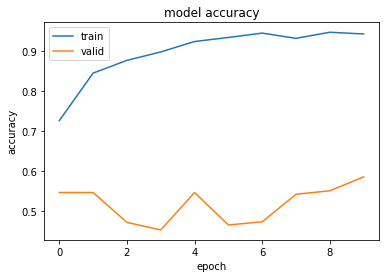

In [ ]:
# plot the training history
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



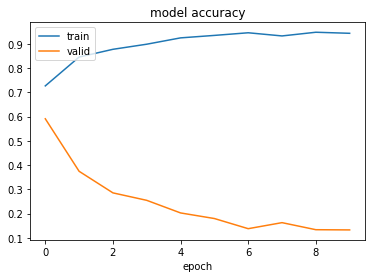

In [ ]:
# plot accuracy and loss
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


In [ ]:
def build_generator(data_path, img_size=(32,32), batch_size=32):
  print('[Build_generators] dir', data_path, 'img:', img_size, 'batch_size', batch_size)
  # initialize the training data augmentation object
  train_aug = tf.keras.preprocessiong.image.ImageDataGenerator(
      rescale=1.0/255,
      rotation_range = 20,
      zoom_range =0.05,
      width_shift_range = 0.05,
      height_shift_range = 0.05,
      shear_range = 0.05,
      horizonal_flip=True,
      fill_mode='nearest')
  
  # initialize the validation (and testing) data augmentation object
  val_aug = tf.keras.preprocesing.image.ImageDataGeerator(rescale=1/255.0)

  # initialize the training generator
  train_path = os.path.join(data_path, 'train')
  print('[build_generators] train', train_path)
  train_gen = train_aug.flow_from_directory(
      directory = train_path, 
      class_mode = "categorical",
      target_size =  img_size,
      #color_mode="rgb"
      shuffle=True,
      batch_size = batch_size
  )

  # initialize the validation generator
  val_path = os.path.join(data_path, 'valid')
  print('[build_generators] test:', test_path)
  test_gen = val_aug.flow_from_directory(
      directory= test_path,
      class_mode = 'categorical',
      target_size = img_size,
      color_mode ='rbg',
      shuffle = False,
      batch_size = batch_size
  )

  return train_gen, val_gen, test_gen

In [ ]:
build_generator('data/practica_DL_UOC_2022/')

[Build_generators] dir data/practica_DL_UOC_2022/ img: (32, 32) batch_size 32


AttributeError: module 'tensorflow.keras' has no attribute 'preprocessiong'

In [ ]:
tf.random.set_seed(42)
def build_model(num_classes, shape, lr=1e-4):
  print('[build-model] num_classes:', num_classes, 'shape:', shape, 'lr', lr)
  inputs = tf.keras.layers.Input(shape=shape, name='input_layer')

  basel_model = tf.keras.aplications.efficientnet.EfficientNetB0(
      include_top=False, weights='imagenet')
  
  # Freeze the pretraineed weights
  base_model.trainable = False
  x = base_model(inputs, training = False)

  # Rebuild top
  x = tf.keras.layer.GlobalAveragePolling2D(name="avg_pool")(x)
  x = tf.keras.layer.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)

  # compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")

  optimizer = tf.keras.optimizers.Adam()
  model.compile(
      optimizer=optimizer,
      loss="categorical_crossentropy",
      metrics=['accuracy']
  )
  return model

In [ ]:
from keras.backend import shape
build_model(2, 32)

[build-model] num_classes: 2 shape: 32 lr 0.0001


AttributeError: module 'tensorflow.keras' has no attribute 'aplications'

In [ ]:
from gc import callbacks
callbacks=[reduce_lr]

In [ ]:
# Fit
total_train = train_gen.samples
total_val = val_gen.samples
total_test =test_gen.samples

steps_per_epoch = total_train // batch_size
validation_steps = total_val // batch_size

print('[train] total_train:', total_train, 'total_val:', total_Val, 'total_test:', total_test, 'epochs:', epochs)
print('[train] steps_per_epoch:', steps_per_epoch)
print('[train] validation_steps:', validtion_steps)
H = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data_val=gen,
    validation_steps=validation_steps,
    epochs=epochs #,callsbacks=callbacks
)

NameError: name 'train_gen' is not defined

### Modelo 2
modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
 A partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas  

### Modelo 3
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
A partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad 


# **Sección 3. Validación cruzada y discusión (3 puntos)**

El objetivo de la técnica de *cross validation* es seleccionar qué modelo es más adecuado, intentando reducir los sesgos y variaciones estadísticas en función de cómo se ha realizado la partición. En los apartados anteriores se ha trabajado con una de las particiones (**fold0**) y se han estudiado 5 modelos distintos.

En este caso, se debe:

- Aplicar una técnica de *cross validation* sobre el mejor de los modelos definidos anteriormente. Los datos ya contienen 10 particiones distintas (de **fold0** a **fold9**), por lo que se debe entrenar el modelo escogido sobre los datos de *train* de cada una de las particiones, evaluarlas, eligiendo en cada caso el mejor modelo de validación.
- Obtener el valor de **F1 score** de cada partición sobre el conjunto de test. De esta forma, se obtendrán 10 valores **F1 score** de test distintos.
- Calcular el valor medio y la desviación estándar.

Finalmente, fíjate en las matrices de *cross validation* que se han obtenido en la sección 2. El Glaucoma es una patología muy grave, por lo que es importante reducir los **falsos negativos (FN)** del modelo. ¿Qué estrategia seguirías para conseguir este propósito y qué penalizaciones podría tener esta decisión?




# **Sección 4. Análisis crítico (1,5 puntos)**

Contesta, de forma razonada y justificada, a las siguientes preguntas:

  a) Para la realización de la práctica se han entregado las *folds* preparadas para el entrenamiento.

  i) Indicar qué estrategia de diseño hubieras seguido si las hubieras tenido que definir tú.

  ii) Indicar qué puntos son importantes en el diseño de estas particiones para que los modelos resultantes tengan una buena capacidad de generalización.

  b) Realizar un análisis crítico de los resultados obtenidos y las conclusiones a las que has llegado después de realizar esta práctica.


8. Entrega

El entregable será un archivo comprimido en formato ZIP con los siguientes documentos:

- **Informe en formato PDF** de entre 8 y 10 páginas de longitud, aproximadamente. No debe contener código (salvo mencionar alguna librería que sea importante indicar, o similar)
- **Código fuente** completo de la práctica. El código usado para todas las etapas de la práctica debe estar correctamente comentado para facilitar su comprensión. Podéis utilizar archivos Python nativos (.py) o basados en Jupyter Notebook (en este caso se debe entregar la versión .ipynb, y la exportación en formato HTML).

Para el **informe** se puede usar la siguiente guía:

- Tamaño de letra 11 o 12
- Fuente: Arial o similar
- Interlineado sencillo
- Las capturas de pantalla (por ejemplo, las gráficas de rendimiento) o los fragmentos de código (si se consideran relevantes) deben estar pensados para ilustrar y no para ser protagonistas.
- Se valora el informe como conjunto y no una sucesión de resultados.
